# Implementing a Variational Autoencoder

In trying to understand [LFADS](https://arxiv.org/abs/1608.06315), I've been spending my time learning about the basis of the model: Variational Autoencoders. Because the current implementation of LFADS is written in Tensorflow, I've also been trying to learn Tensorflow. Thus, I'm going to put my knowledge of VAEs and TF to the test by implementing my own Variational Autoencoder!

My understanding of VAEs is largely due to [Carl Doersch's tutorial](https://arxiv.org/abs/1606.05908). 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
# Input to the graph -- Tensorflow's MNIST images are (1, 784) vectors
n_pixels = 28*28
X = tf.placeholder(tf.float32, shape=([None, n_pixels]))

In [3]:
#layer creation functions
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def FC_layer(X, W, b):
    return tf.matmul(X, W) + b

## Encoder
The encoder consists of a 2 layer, fully connected feed forward network that reduces the dimensionality from the original number of features (e.g. pixel) to the dimensionality of the latent space. This network has two outputs -- the mean and (log) standard deviation of a gaussian distribution.

In [4]:
# encoder
latent_dim = 20
h_dim = 500

W_enc = weight_variable([n_pixels, h_dim], 'W_enc')
b_enc = bias_variable([h_dim], 'b_enc')
# tanh activation function to replicate original model
h_enc = tf.nn.tanh(FC_layer(X, W_enc, b_enc))

W_mu = weight_variable([h_dim, latent_dim], 'W_mu')
b_mu = bias_variable([latent_dim], 'b_mu')
mu = FC_layer(h_enc, W_mu, b_mu)

W_logstd = weight_variable([h_dim, latent_dim], 'W_logstd')
b_logstd = bias_variable([latent_dim], 'b_logstd')
logstd = FC_layer(h_enc, W_logstd, b_logstd)

# reparameterization trick
noise = tf.random_normal([1, latent_dim])
z = mu + tf.mul(noise, tf.exp(.5*logstd))

## Decoder

The decoder (or, in the language of LFADS, the 'generator') is also a feedforward, fully connected network -- however, it goes from the dimensionality of the latent space back to the original dimensionality of the data (e.g. pixels). The output of the network is squashed between 0 and 1 with a sigmoid function.

In [5]:
# decoder
W_dec = weight_variable([latent_dim, h_dim], 'W_dec')
b_dec = bias_variable([h_dim], 'b_dec')
h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))

W_reconstruct = weight_variable([h_dim, n_pixels], 'W_reconstruct')
b_reconstruct = bias_variable([n_pixels], 'b_reconstruct')
reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruct, b_reconstruct))

## Loss function
Each of these outputs is taken to be the mean of a Bernoulli distribution (in this example, a Bernoulli distribution is appropriate because our data is binary). The variational lower bound is given by:

\begin{equation}
\mathcal{L} = \mathbb{E}_{z\sim Q(z|X)}\log P(X|z) - D(Q(z|X)||P(z))
\end{equation}

When $P$ is a Bernouli distribution, the log likelihood is given by

\begin{equation}
\log P(X|z) = \sum_i^N X^{(i)}\log y^{(i)} + (1 − X^{(i)}) \cdot \log(1 − y^{(i)})
\end{equation}

where $N$ is the number of training samples (in our case, the batchsize), and $y^{(i)}$ is the reconstruction from the latent code $z^{(i)}$. The KL divergence between a gaussian $Q$ with mean $\mu$ and standard deviation $\sigma$ and a standard normal distribution $P$ is given by:

\begin{equation}
D(Q||P) = -\frac{1}{2}\sum_j^J \big(1 + \log((\sigma_j)^2) - (\mu_j)^2 - (\sigma_j)^2\big)
\end{equation}

We want to maximize this lower bound, but because tensorflow doesn't have a 'maximizing' optimizer, we minimize the negative lower bound.

In [6]:
# variational lower bound

# add epsilon to log to prevent numerical overflow
log_likelihood = tf.reduce_sum(X*tf.log(reconstruction + 1e-9)+(1 - X)*tf.log(1 - reconstruction + 1e-9), reduction_indices=1)
KL_term = -.5*tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)
variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)

## Training

Now all we have to do is run the optimizer until convergence. 

In [7]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
saver = tf.train.Saver()

In [12]:
import time

num_iterations = 1000000
recording_interval = 1000
variational_lower_bound_array = []
log_likelihood_array = []
KL_term_array = []
iteration_array = [i*recording_interval for i in range(num_iterations/recording_interval)]
for i in range(num_iterations):
    # np.round to make MNIST binary
    x_batch = np.round(mnist.train.next_batch(200)[0])
    sess.run(optimizer, feed_dict={X: x_batch})
    if (i%recording_interval == 0):
        vlb_eval = variational_lower_bound.eval(feed_dict={X: x_batch})
        print "Iteration: {}, Loss: {}".format(i, vlb_eval)
        variational_lower_bound_array.append(vlb_eval)
        log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={X: x_batch})))
        KL_term_array.append(np.mean(KL_term.eval(feed_dict={X: x_batch})))

Iteration: 0, Loss: -236.021286011
Iteration: 1000, Loss: -228.880111694
Iteration: 2000, Loss: -235.156402588
Iteration: 3000, Loss: -235.000747681
Iteration: 4000, Loss: -230.577148438
Iteration: 5000, Loss: -236.92590332
Iteration: 6000, Loss: -227.564880371
Iteration: 7000, Loss: -230.312072754
Iteration: 8000, Loss: -238.945617676
Iteration: 9000, Loss: -237.638305664
Iteration: 10000, Loss: -231.152618408
Iteration: 11000, Loss: -226.153518677
Iteration: 12000, Loss: -219.754104614
Iteration: 13000, Loss: -224.015426636
Iteration: 14000, Loss: -228.482345581
Iteration: 15000, Loss: -227.824279785
Iteration: 16000, Loss: -221.535858154
Iteration: 17000, Loss: -231.035705566
Iteration: 18000, Loss: -228.021835327
Iteration: 19000, Loss: -225.699645996
Iteration: 20000, Loss: -220.126724243
Iteration: 21000, Loss: -216.616394043
Iteration: 22000, Loss: -219.514373779
Iteration: 23000, Loss: -234.833404541
Iteration: 24000, Loss: -225.963150024
Iteration: 25000, Loss: -216.578323364


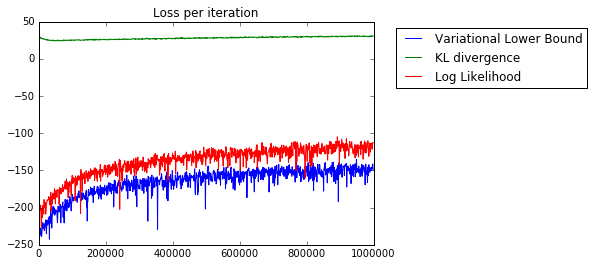

In [14]:
plt.figure()
plt.plot(iteration_array, variational_lower_bound_array)
plt.plot(iteration_array, KL_term_array)
plt.plot(iteration_array, log_likelihood_array)
plt.legend(['Variational Lower Bound', 'KL divergence', 'Log Likelihood'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Loss per iteration')

## Results

Here, we plot the reconstructed image on test set images.

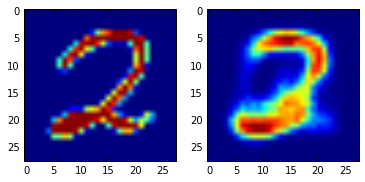

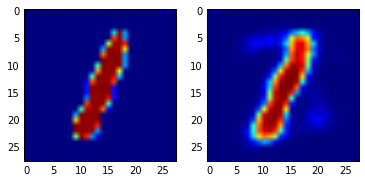

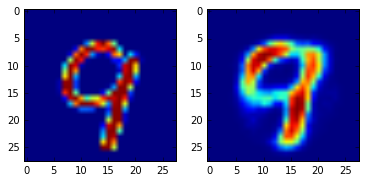

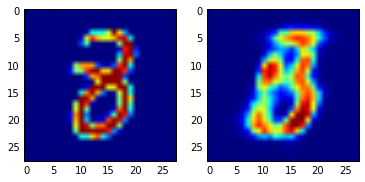

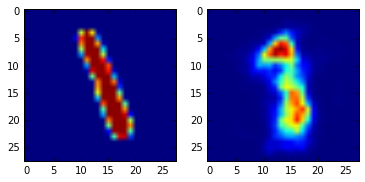

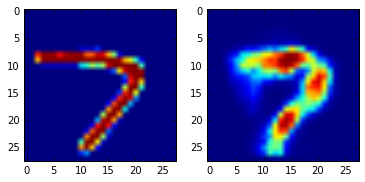

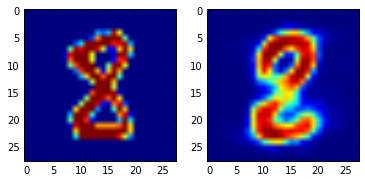

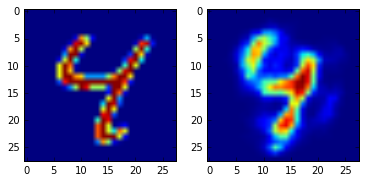

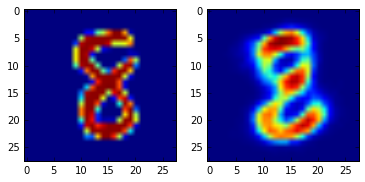

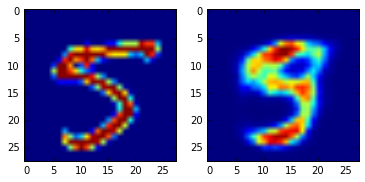

In [19]:
import os
load_model = False
if load_model:
    saver.restore(sess, os.path.join(os.getcwd(), "Trained Bernoulli VAE"))

num_pairs = 10
image_indices = np.random.randint(0, 200, num_pairs)
for pair in range(num_pairs):
    x = np.reshape(mnist.test.images[image_indices[pair]], (1,n_pixels))
    plt.figure()
    x_image = np.reshape(x, (28,28))
    plt.subplot(121)
    plt.imshow(x_image)
    x_reconstruction = reconstruction.eval(feed_dict={X: x})
    x_reconstruction_image = (np.reshape(x_reconstruction, (28,28)))
    plt.subplot(122)
    plt.imshow(x_reconstruction_image)